# Explore SGP's ARM data, detrend and apply bias correction
- In this notebook, we process Southern Great Plain's (SGP) Atmospheric Radiation Measurement (ARM) data.
- There is one file per day with hourly (?) data.
- So, we compute daily max for the variable temperature and store it in a zarr store.
- We fill missing data with NaNs.
- Before doing analysis on days of the year with one or more NaNs for the period 1994-2024, please resample and fill the NaNs
- In this notebook, we use data for the day Jul 30 which doesn't have missing data

In [1]:
import numpy as np
import xarray as xr
from distributed import Client
import dask_jobqueue
import matplotlib.pyplot as plt
import matplotlib as mtplt
import glob
# import netCDF4 as nc
import zarr
import nc_time_axis
import xskillscore as xs
import cartopy as cart
#np.set_printoptions(threshold=np.inf)
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from datetime import datetime, timedelta
import pandas as pd
from statsmodels.distributions.empirical_distribution import ECDF

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/numba/core/cpu.py:78: UserWarning: Numba extension module 'numba_scipy' failed to load due to 'ContextualVersionConflict((numpy 1.23.5 (/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages), Requirement.parse('numpy<1.23.0,>=1.16.5'), {'scipy'}))'.
  numba.core.entrypoints.init_all()
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/numba/core/cpu.py:78: UserWarning: Numba extension module 'sparse._numba_extension' failed to load due to 'ContextualVersionConflict((numpy 1.23.5 (/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages), Requirement.parse('numpy<1.2

In [2]:
#
sgp_lat   = 36.607
sgp_lon   = (360-97.487)%360

#36.607322° N and 97.487643° W
########## CONUS ############
#CONUS lat-lon
top       = 50.0 # north lat
left      = -124.7844079+360 # west long
right     = -66.9513812+360 # east long
bottom    =  24.7433195 # south lat
################################
sgp_path     =  '/global/scratch/users/harsha/SGP/'
sgp_rawdpath = sgp_path + 'raw_data/'
#
cesm2_path = '/global/scratch/users/harsha/LENS/cesm2/tasmax/'
cvals      = '/global/scratch/users/harsha/LENS/cesm2/cvals/bias/'
print(sgp_lat,sgp_lon)

36.607 262.51300000000003


In [3]:
def to_daily(ds):
    year = ds.time.dt.year
    day  = ds.time.dt.dayofyear

    # assign new coords
    ds = ds.assign_coords(year=("time", year.data), day=("time", day.data))

    # reshape the array to (..., "day", "year")
    return ds.set_index(time=("year", "day")).unstack("time") 

def is_sorted(arr):
    return np.all(arr[:-1] <= arr[1:]) or np.all(arr[:-1] >= arr[1:])

In [4]:
def no_leap_date(day_of_year):
    # Start from the first day of a non-leap year
    start_date = datetime(2021, 1, 1)

    # Calculate the actual date (subtract 1 because January 1st is day 1)
    actual_date = start_date + timedelta(days=day_of_year - 1)

    # Format the date to get 'Month Day'
    return actual_date.strftime('%B %d')

In [5]:
def detrend(ds, central_year):
    # Assumes that the ds has coordinates day, year and member.
    
    #Fit a linear fuction and extract slope
    pcoeffs = ds.mean('member').polyfit(dim='year',deg=1)
    slope   = pcoeffs.polyfit_coefficients.sel(degree=1)
    
    #Calculate trend
    ds_trend   = slope*(ds['year']- central_year)
    
    #Detrend by subtracting the trend from the data
    ds_detrended = ds  - ds_trend
    
    return ds_detrended

In [6]:
quants = np.linspace(0,1.0,30)
def compute_quantiles(ds, quantiles=quants):
    return ds.chunk(dict(year=-1)).quantile(quantiles, dim='year',skipna=False)

def implement_mdm(ds_obs,init_mean,final_mean,init_std,final_std):
    # Assuming coordinates year and day for ds_obs
    obs_mean = ds_obs.mean('year')
    sratio   = final_std/init_std
    ds_mdm   = obs_mean + (final_mean - init_mean) + sratio*(ds_obs - obs_mean)        
    return ds_mdm

def implement_shift(ds_obs,init_mean,final_mean):
    # Assuming coordinates year and day for ds_obs
    obs_mean   = ds_obs.mean('year')
    ds_shift   = obs_mean + (final_mean - init_mean) + ds_obs - obs_mean        
    return ds_shift

def implement_qdm(qobs, qinit, qfinal):
    # Implement quantile delta mapping. Assumes model data has corrd called 'mtime'
    #qinit    = init_data.quantile(quants,dim='mtime')
    #qfinal   = final_data.quantile(quants,dim='mtime')
    ds_qdm   = qobs + (qfinal - qinit)
    return ds_qdm

def is_sorted(arr):
    return np.all(arr[:-1] <= arr[1:]) or np.all(arr[:-1] >= arr[1:])

def min_sorting(arr):
    # Convert to a NumPy array if not already
    arr = np.array(arr)

    # Find indices where the array is not sorted
    unsorted_indices = np.where(arr[:-1] > arr[1:])[0]

    # Iterate through unsorted indices and min with minimum of subsequent values
    for i in unsorted_indices:
        arr[i] = np.min(arr[i:])
    
    # Adjust for duplicates
    unique_elements, counts = np.unique(arr, return_counts=True)
    duplicates              = unique_elements[counts > 1]

    for d in duplicates:
        indices = np.where(arr == d)[0]
        for i, idx in enumerate(indices):
            arr[idx] += i * 1e-4

    return arr

In [7]:
job_extra = ['--qos=cf_lowprio','--account=ac_cumulus'] 
#job_extra =['--qos=lr6_lowprio','--account=ac_cumulus','--constraint=lr6_m192']
#job_extra =['--qos=condo_cumulus_lr6','--account=lr_cumulus','--constraint=lr6_m192']
#job_extra =['--qos=lr_lowprio','--account=ac_cumulus']
cluster = dask_jobqueue.SLURMCluster(queue="cf1", cores=10, walltime='5:00:00', 
                local_directory='/global/scratch/users/harsha/dask_space/', 
                log_directory='/global/scratch/users/harsha/dask_space/', 
                job_extra_directives=job_extra, interface='eth0', memory="192GB") 
client  = Client(cluster) 
cluster.scale_up(1)

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33903 instead
  warnings.warn(


In [8]:
pi_year0  = '1850'
pi_year1  = '1879'
#
ic_year0  = '2071'
ic_year1  = '2100'
#
sgp_year0 = '1994'
sgp_year1 = '2023'
#
pi_year   = 1865
eoc_year  = 2085
sgp_year  = 2009
doy       = 211 # day_of_year
date = no_leap_date(doy)
date

'July 30'

In [9]:
cluster

Dashboard: http://10.0.39.1:33903/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.39.1:40487,Workers: 0
Dashboard: http://10.0.39.1:33903/status,Total threads: 0
Started: Just now,Total memory: 0 B


### Test file paths by reading one year's worth of data

In [10]:
# Define the start and end dates
start_date = datetime(2013, 1, 1)
end_date   = datetime(2013, 12, 31)

# Define string1 and string2
string1 = sgp_rawdpath +'sgpmetE13.b1.'
string2 = '.000000.cdf'

# Generate the dates and create file paths
file_paths = []
current_date = start_date
#
while current_date <= end_date:
    date_str = current_date.strftime('%Y%m%d')
    file_path = string1 + date_str + string2
    file_paths.append(file_path)
    current_date += timedelta(days=1)

# file_paths now contains all the generated file paths
# print(file_paths)

In [11]:
# %%time
# sgp = xr.open_mfdataset(file_paths,combine='nested',concat_dim='time')
# sgp

### Process observations (ARM) data, compute daily max and write files to daily file

In [12]:
# Define string1 and string2
string1 = sgp_rawdpath +'sgpmetE13.b1.'
string2 = '.000000.cdf'
variable_name = 'temp_mean'  # The variable you want to extract
#
year_0      = 1993
year_1      = 2023

In [13]:
# %%time
# yearly_data_arrays = []

# for year in range(year_0, year_1 + 1):
#     daily_max_values = []

#     # Iterate over each day of the year
#     for day in pd.date_range(start=f'{year}-01-01', end=f'{year}-12-31'):
#         date_str = day.strftime('%Y%m%d')
#         file_path = string1 + date_str + string2

#         try:
#             with xr.open_dataset(file_path) as ds:
#                 daily_max = ds[variable_name].max(dim='time')
#                 daily_max_values.append(daily_max.values)
#         except (FileNotFoundError):
#             # print(f"File not found: {file_path}")
#             daily_max_values.append(np.nan)  # Append NaN for missing data

#     # Combine daily maximum values into a DataArray for the year
#     yearly_data = xr.DataArray(daily_max_values, dims=["dayofyear"], coords={"dayofyear": pd.date_range(start=f'{year}-01-01',\
#                                                                             end=f'{year}-12-31').dayofyear, "year": year})
#     yearly_data_arrays.append(yearly_data)

# # Concatenate all yearly data arrays along the new 'year' coordinate
# all_years_data = xr.concat(yearly_data_arrays, dim='year')
# all_years_data = all_years_data.rename('daily_tmax')
# # Save the concatenated data to a single file
# all_years_data.to_dataset().to_zarr(sgp_path + 'tmax_sgp_obs.zarr',mode='w')

In [14]:
sgp_tmax_obs = xr.open_zarr(sgp_path + 'tmax_sgp_obs.zarr').daily_tmax
sgp_tmax_obs

<xarray.DataArray 'daily_tmax' (year: 31, dayofyear: 366)>
dask.array<open_dataset-6fa02056074e598fedb53a5137a06392daily_tmax, shape=(31, 366), dtype=float64, chunksize=(31, 366), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366
  * year       (year) int64 1993 1994 1995 1996 1997 ... 2020 2021 2022 2023

In [15]:
%%time
sgp_tmax_obs.sel(dayofyear=doy).values

CPU times: user 12.4 s, sys: 523 ms, total: 12.9 s
Wall time: 46.4 s


array([        nan, 30.52000046, 32.65999985, 31.95999908, 29.54000092,
       35.84999847, 40.25      , 30.81999969, 38.52000046, 33.11000061,
       34.72000122, 21.62000084, 36.33000183, 38.16999817, 33.20999908,
       34.79000092, 27.48999977, 36.66999817, 38.70999908, 42.79000092,
       30.51000023, 28.29000092, 29.39999962, 28.30999947, 31.43000031,
       30.07999992, 36.18000031, 32.29000092, 37.91999817, 28.45000076,
       38.5       ])

### Drop data for 366th day, the year 1993 and convert to Kelvin

In [60]:
%%time
sgp_obs = sgp_tmax_obs.drop_isel(dayofyear = 365, year=0).rename({'dayofyear':'day'}) + 273.15
sgp_obs.sel(day=doy).dropna(dim='year').values

CPU times: user 362 ms, sys: 29.3 ms, total: 391 ms
Wall time: 484 ms


array([303.67000046, 305.80999985, 305.10999908, 302.69000092,
       308.99999847, 313.4       , 303.96999969, 311.67000046,
       306.26000061, 307.87000122, 294.77000084, 309.48000183,
       311.31999817, 306.35999908, 307.94000092, 300.63999977,
       309.81999817, 311.85999908, 315.94000092, 303.66000023,
       301.44000092, 302.54999962, 301.45999947, 304.58000031,
       303.22999992, 309.33000031, 305.44000092, 311.06999817,
       301.60000076, 311.65      ])

### Quantile function

#### Resample and fill-in missing values

In [17]:
# # Set the random seed for reproducibility
# random_state = 42
# np.random.seed(random_state)
# sgp_tmax_dobs = sgp_tmax_obs.sel(day=doy).values
# # Identify non-missing values
# non_missing = sgp_tmax_dobs[~np.isnan(sgp_tmax_dobs)]

# # Randomly sample from non-missing values
# # The size of the sample is equal to the number of missing values
# sampled_values = np.random.choice(non_missing, size=np.isnan(sgp_tmax_dobs).sum())

# # Fill in the missing values
# sgp_tmax_dobs[np.isnan(sgp_tmax_dobs)] = sampled_values
# sgp_tmax_dobs

### Now get model data 

In [18]:
# %%time
# ds_ssp0  = xr.open_mfdataset(cesm2_path+'ssp370_cesm2tmax.zarr',engine='zarr').TREFHTMX
# ds_hist0 = xr.open_mfdataset(cesm2_path+'bhist_cesm2tmax.zarr',engine='zarr').TREFHTMX
# #
# ds_ssp      = ds_ssp0.drop_isel({'time':-1})         #Drop Jan 1, 2101 data
# ds_hist     = ds_hist0.drop_isel({'time':-1})        #Drop an extra copy of Jan 1, 2015 data
# ds_tmax     = xr.concat([ds_hist,ds_ssp],dim='time')
# #
# sgp_model_tmax   = ds_tmax.sel(lat=sgp_lat,lon=sgp_lon,method ='nearest')
# sgp_model_tmax   = sgp_model_tmax.chunk({'member':100,'time':3650})

# Save SGP data
# sgp_model_tmax.to_dataset().to_zarr(sgp_path + 'sgp_model_tmax.zarr',mode='w')

In [19]:
%%time
sgp_model_tmax = xr.open_zarr(sgp_path + 'sgp_model_tmax.zarr').TREFHTMX
sgp_model_tmax

CPU times: user 3.05 s, sys: 345 ms, total: 3.4 s
Wall time: 3.55 s


<xarray.DataArray 'TREFHTMX' (time: 91615, member: 100)>
dask.array<open_dataset-d669b61fa2344309894d6b1df41948c9TREFHTMX, shape=(91615, 100), dtype=float32, chunksize=(3650, 100), chunktype=numpy.ndarray>
Coordinates:
    lat      float64 ...
    lon      float64 ...
  * member   (member) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
  * time     (time) object 1850-01-01 00:00:00 ... 2100-12-31 00:00:00
Attributes:
    cell_methods:  time: maximum
    long_name:     Maximum reference height temperature over output period
    units:         K

### Convert to daily data and detrend

In [20]:
%%time
#d = daily
sgp_model_dtmax = to_daily(sgp_model_tmax)
sgp_model_dtmax

CPU times: user 2.48 s, sys: 98.3 ms, total: 2.58 s
Wall time: 2.58 s


<xarray.DataArray 'TREFHTMX' (member: 100, year: 251, day: 365)>
dask.array<reshape, shape=(100, 251, 365), dtype=float32, chunksize=(100, 10, 365), chunktype=numpy.ndarray>
Coordinates:
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2096 2097 2098 2099 2100
  * day      (day) int64 1 2 3 4 5 6 7 8 9 ... 358 359 360 361 362 363 364 365
    lat      float64 ...
    lon      float64 ...
  * member   (member) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
Attributes:
    cell_methods:  time: maximum
    long_name:     Maximum reference height temperature over output period
    units:         K

In [21]:
# Cur = current, EOC - End of century
sgp_model_cur    = sgp_model_dtmax.sel(year=slice(sgp_year0,sgp_year1))
sgp_model_eoc    = sgp_model_dtmax.sel(year=slice(ic_year0,ic_year1))
#
sgp_eoc_det      = detrend(sgp_model_eoc,eoc_year)
sgp_cur_det      = detrend(sgp_model_cur,sgp_year)
sgp_year0

'1994'

CPU times: user 2.32 s, sys: 126 ms, total: 2.45 s
Wall time: 5.46 s


Text(0.5, 1.0, 'CESM2 data for SGP and day = July 30')

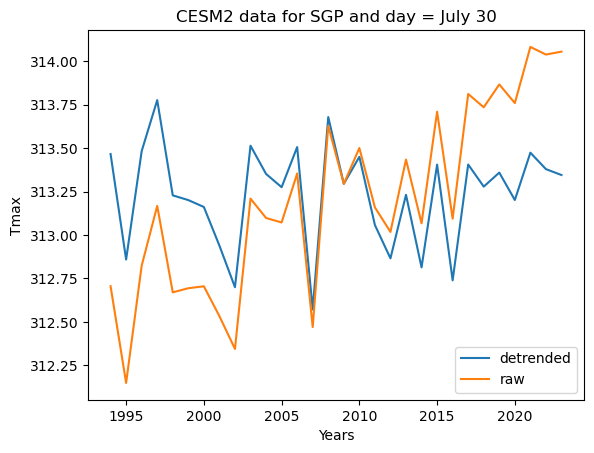

In [22]:
%%time
plt.plot(np.arange(1994,2024,1),sgp_cur_det.mean('member').sel(day=doy),label='detrended')
plt.plot(np.arange(1994,2024,1), sgp_model_cur.mean('member').sel(day=doy), label ='raw')
plt.xlabel('Years')
plt.ylabel('Tmax')
plt.legend(loc='lower right')
plt.title('CESM2 data for SGP and day = ' + date)

CPU times: user 1.51 s, sys: 92.8 ms, total: 1.6 s
Wall time: 2.74 s


Text(0.5, 1.0, 'CESM2 data for SGP and day = July 30')

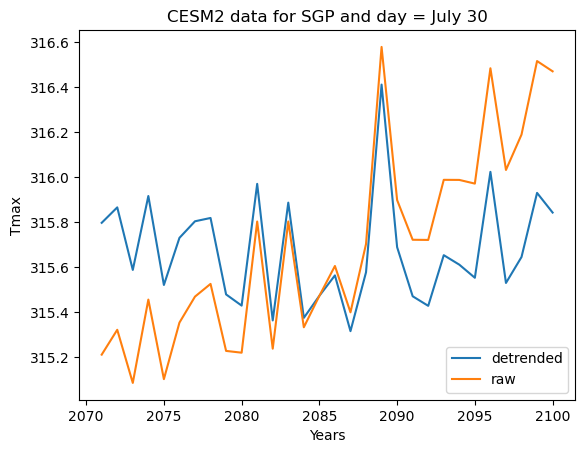

In [23]:
%%time
plt.plot(np.arange(2071,2101,1),sgp_eoc_det.mean('member').sel(day=doy),label='detrended')
plt.plot(np.arange(2071,2101,1), sgp_model_eoc.mean('member').sel(day=doy), label ='raw')
plt.xlabel('Years')
plt.ylabel('Tmax')
plt.legend(loc='lower right')
plt.title('CESM2 data for SGP and day = ' + date)

### Apply Moment Delta Mapping and Quantile Delta Mapping

In [24]:
sgp_eoc_mean = sgp_eoc_det.mean({'member','year'})
sgp_eoc_std  = sgp_eoc_det.std({'member','year'})
#
sgp_cur_mean = sgp_cur_det.mean({'member','year'})
sgp_cur_std  = sgp_cur_det.std({'member','year'})

In [25]:
#### Temp #####
sgp_cur_mean.sel(day=doy).values, sgp_eoc_mean.sel(day=doy).values

(array(313.23343438), array(315.6746803))

In [26]:
sgp_cur_std.sel(day=doy).values, sgp_eoc_std.sel(day=doy).values

(array(3.09399128), array(3.30985021))

In [59]:
sgp_mdm

<xarray.DataArray (dayofyear: 366, day: 365, year: 31)>
dask.array<add, shape=(366, 365, 31), dtype=float64, chunksize=(366, 365, 31), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366
  * day        (day) int64 1 2 3 4 5 6 7 8 9 ... 358 359 360 361 362 363 364 365
    lat        float64 36.28
    lon        float64 262.5
    degree     int64 1
  * year       (year) int64 1993 1994 1995 1996 1997 ... 2020 2021 2022 2023

In [62]:
sgp_mdm   =   implement_mdm(sgp_obs,sgp_cur_mean,sgp_eoc_mean,sgp_cur_std,sgp_eoc_std)
#sgp_mdm.sel(day=doy).values

In [63]:
%%time
# Compute quantiles
qsgp_mdm = compute_quantiles(sgp_mdm)
qsgp_obs = compute_quantiles(sgp_obs)
#
qsgp_cur = sgp_model_cur.stack(mtime=('member','year'),create_index=False).chunk(dict(mtime=-1)).quantile(quants, dim='mtime',skipna=False)
qsgp_eoc = sgp_model_eoc.stack(mtime=('member','year'),create_index=False).chunk(dict(mtime=-1)).quantile(quants, dim='mtime',skipna=False)
#
qdeltas = qsgp_eoc - qsgp_cur
qsgp_qdm = implement_qdm(qsgp_obs,qsgp_cur,qsgp_eoc)

CPU times: user 223 ms, sys: 11 ms, total: 234 ms
Wall time: 231 ms


In [64]:
# Now, calculate QDM + sort
qsgp_sqdm  = xr.apply_ufunc(
    np.sort,
    qsgp_qdm,
    input_core_dims=[['quantile']],
    output_core_dims=[['quantile']],
    dask='parallelized'
)
qsgp_sqdm

<xarray.DataArray (day: 365, quantile: 30)>
dask.array<transpose, shape=(365, 30), dtype=float64, chunksize=(365, 30), chunktype=numpy.ndarray>
Coordinates:
  * day       (day) int64 1 2 3 4 5 6 7 8 9 ... 358 359 360 361 362 363 364 365
  * quantile  (quantile) float64 0.0 0.03448 0.06897 0.1034 ... 0.931 0.9655 1.0

## Plot curves, one technique at a time

CPU times: user 2.52 s, sys: 141 ms, total: 2.67 s
Wall time: 3.86 s


Text(0, 0.5, 'Quantile function (K)')

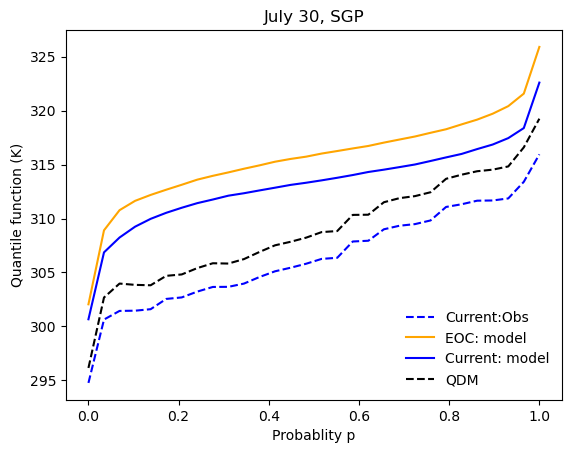

In [65]:
%%time
# First plot QDM to show quantile crossings
plt.plot(quants,qsgp_obs.sel(day=doy),'b--', label ='Current:Obs')
plt.plot(quants,qsgp_eoc.sel(day=doy),color= 'orange', label='EOC: model')
plt.plot(quants,qsgp_cur.sel(day=doy), color='blue',label ='Current: model')
plt.plot(quants,qsgp_qdm.sel(day=doy),'k--',label='QDM')
plt.title(date + ','+ ' SGP')
plt.xlabel('Probablity p')
plt.legend(loc='lower right',frameon = False)
plt.ylabel('Quantile function (K)')

In [66]:
# Are there quantile crossings?
is_sorted(qsgp_qdm.sel(day=doy).values)

False

In [67]:
# Does sorting fix it?
is_sorted(qsgp_sqdm.sel(day=doy).values)

True

In [68]:
is_sorted(qsgp_mdm.sel(day=doy).values)

True

In [69]:
qsgp_mdm.sel(day=doy).values

array([296.39615729, 302.67568928, 303.53150422, 303.55289801,
       303.7026668 , 304.71894436, 304.86871314, 305.44638634,
       305.90638654, 305.91708445, 306.23801378, 306.89057239,
       307.45754767, 307.81057279, 308.20638549, 308.68778152,
       308.7947566 , 310.41010727, 310.48499064, 311.6189412 ,
       311.97196632, 312.13243302, 312.49614993, 313.83335886,
       314.10080065, 314.45382576, 314.4752216 , 314.67847588,
       316.32591826, 319.04312778])

Text(0, 0.5, 'Quantile function (K)')

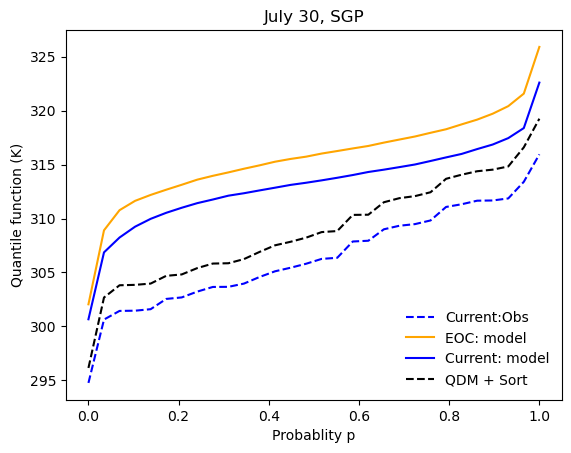

In [70]:
# QDM + Sort
plt.plot(quants,qsgp_obs.sel(day=doy),'b--', label ='Current:Obs')
plt.plot(quants,qsgp_eoc.sel(day=doy),color= 'orange', label='EOC: model')
plt.plot(quants,qsgp_cur.sel(day=doy), color='blue',label ='Current: model')
plt.plot(quants,qsgp_sqdm.sel(day=doy),'k--',label='QDM + Sort')
plt.title(date + ','+ ' SGP')
plt.xlabel('Probablity p')
plt.legend(loc='lower right',frameon = False)
plt.ylabel('Quantile function (K)')

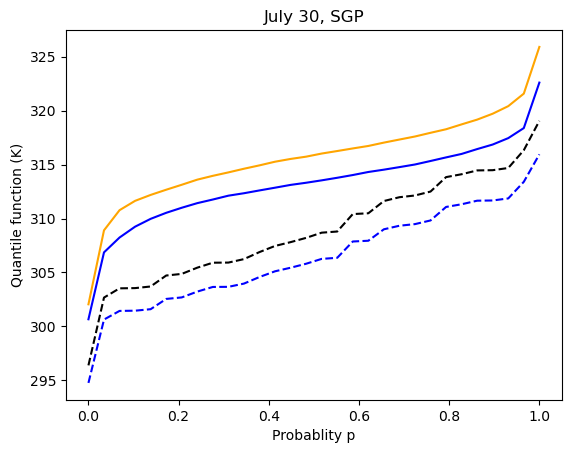

CPU times: user 3.94 s, sys: 241 ms, total: 4.18 s
Wall time: 5.4 s


In [71]:
%%time
# Finally, plot MDM 
plt.plot(quants,qsgp_obs.sel(day=doy),'b--', label ='Current:Obs')
plt.plot(quants,qsgp_eoc.sel(day=doy),color= 'orange', label='EOC: model')
plt.plot(quants,qsgp_cur.sel(day=doy), color='blue',label ='Current: model')
plt.plot(quants,qsgp_mdm.sel(day=doy),'k--',label='MDM')
plt.title(date + ','+ ' SGP')
#plt.legend(loc='lower right',frameon = False)
plt.xlabel('Probablity p')
plt.ylabel('Quantile function (K)')
plt.show()

CPU times: user 7.62 s, sys: 394 ms, total: 8.02 s
Wall time: 11.6 s


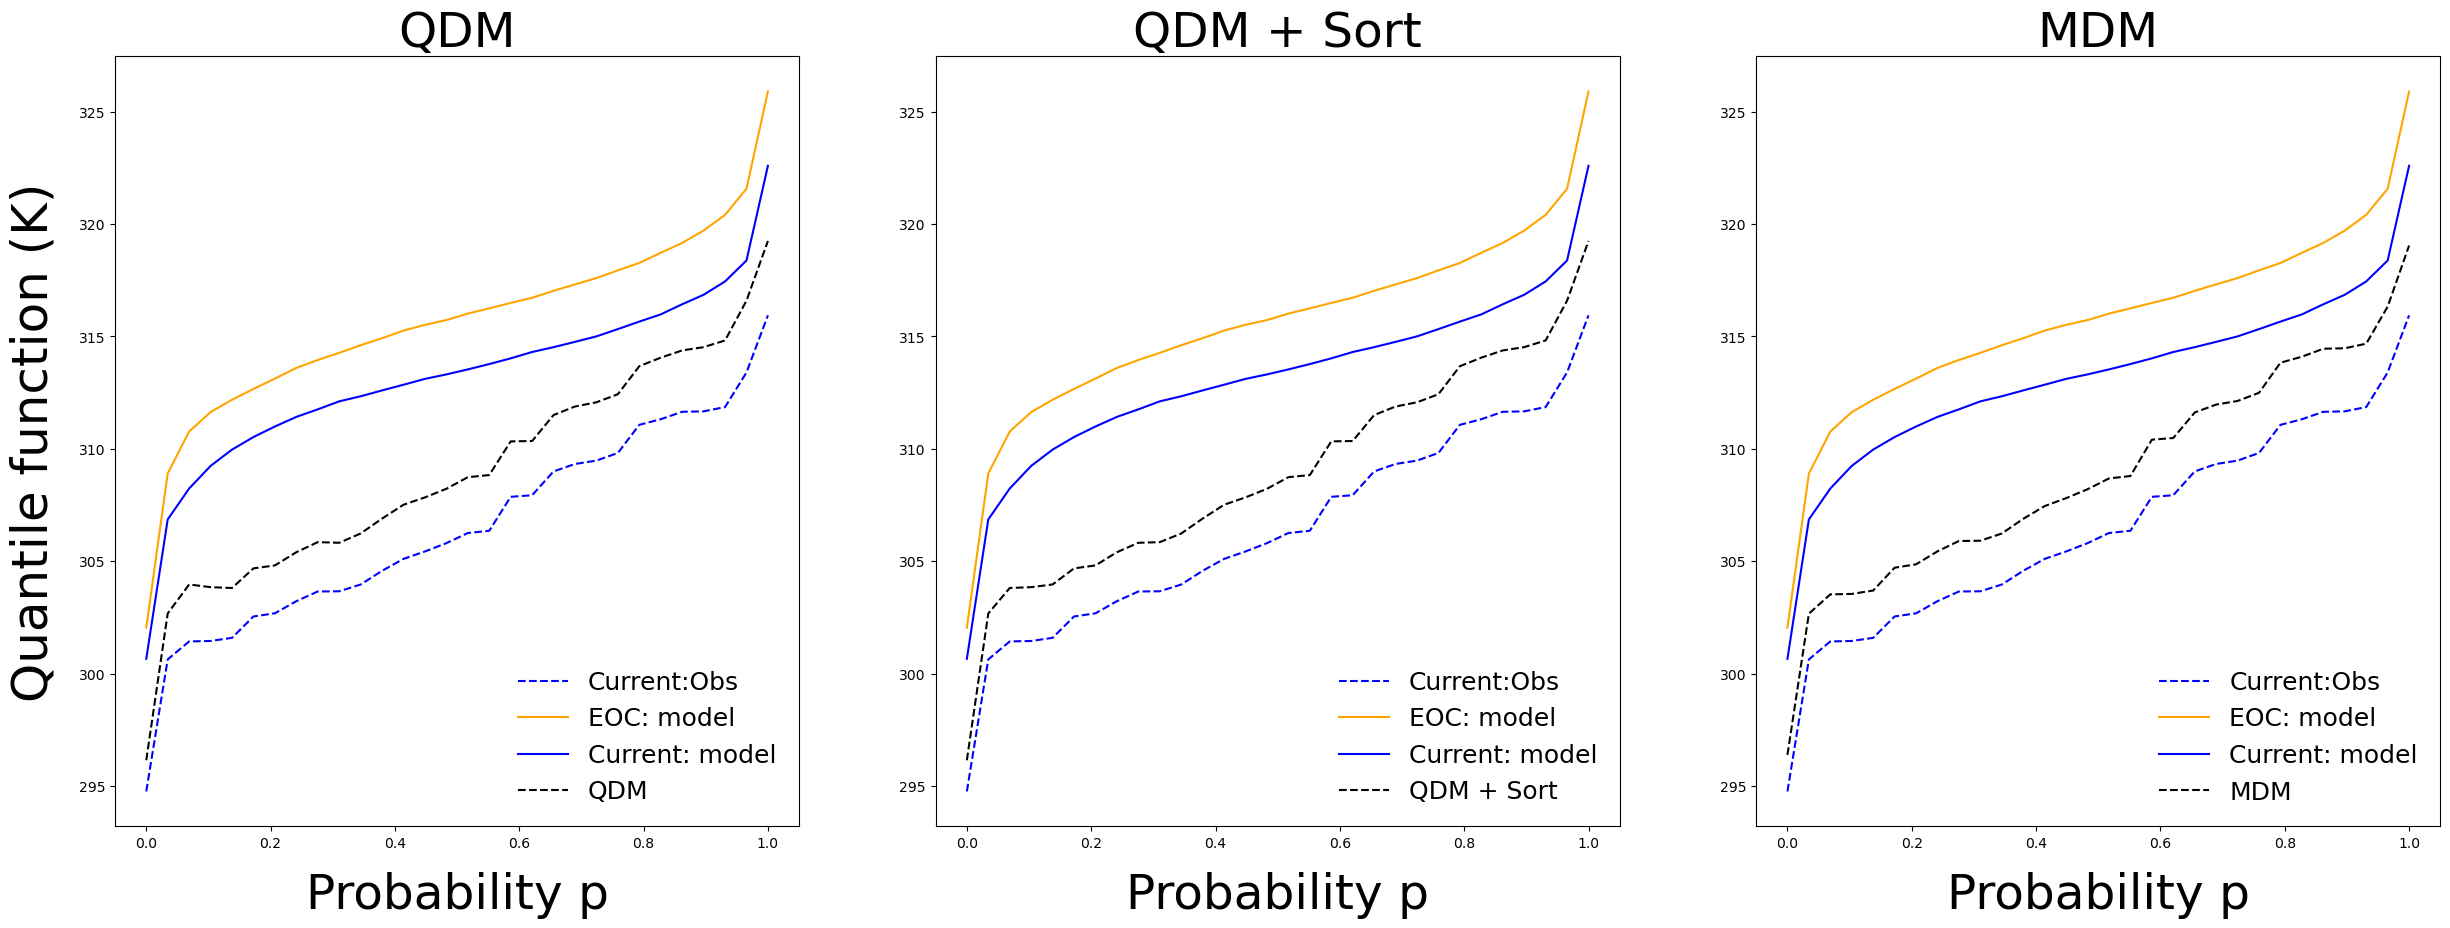

In [73]:
%%time
# Plot the 3 figures as a 3-panel plot
# Setting up the figure and subplots
fig, axs = plt.subplots(1, 3, figsize=(30, 10)) # 3 plots - side by side

#Plot for QDM
axs[0].plot(quants,qsgp_obs.sel(day=doy),'b--', label ='Current:Obs')
# axs[0].plot(quants,qsgp_eoc.sel(day=doy),color= 'orange', label='EOC: model')
# axs[0].plot(quants,qsgp_cur.sel(day=doy), color='blue',label ='Current: model')
axs[0].plot(quants,qsgp_qdm.sel(day=doy),'k--',label='QDM')
axs[0].set_ylabel('Quantile function (K)',fontweight=500,fontsize=36,labelpad=15)
axs[0].set_xlabel('Probability p',fontweight=500,fontsize=35,labelpad=15)
axs[0].set_title('QDM',fontweight=500,fontsize=35)
axs[0].legend(loc='lower right',prop={'size': 18},frameon=False)

#Plot for QDM + sort
axs[1].plot(quants,qsgp_obs.sel(day=doy),'b--', label ='Current:Obs')
# axs[1].plot(quants,qsgp_eoc.sel(day=doy),color= 'orange', label='EOC: model')
# axs[1].plot(quants,qsgp_cur.sel(day=doy), color='blue',label ='Current: model')
axs[1].plot(quants,qsgp_sqdm.sel(day=doy),'k--',label='QDM + Sort')
axs[1].set_xlabel('Probability p',fontweight=500,fontsize=35,labelpad=15)
axs[1].set_title('QDM + Sort',fontweight=500,fontsize=35)
axs[1].legend(loc='lower right',prop={'size': 18},frameon=False)

#Plot for MDM
axs[2].plot(quants,qsgp_obs.sel(day=doy),'b--', label ='Current:Obs')
# axs[2].plot(quants,qsgp_eoc.sel(day=doy),color= 'orange', label='EOC: model')
# axs[2].plot(quants,qsgp_cur.sel(day=doy), color='blue',label ='Current: model')
axs[2].plot(quants,qsgp_mdm.sel(day=doy),'k--',label='MDM')
axs[2].set_xlabel('Probability p',fontweight=500,fontsize=35,labelpad=15)
axs[2].set_title('MDM',fontweight=500,fontsize=35)
axs[2].legend(loc='lower right',prop={'size': 18},frameon=False)

## Ignore code below this line

### Sort and check PDF

In [37]:
# %%time
# day0 = 51
# is_sorted(qsgp_mdm.sel(day=doy).to_numpy())

In [38]:
is_sorted(qsgp_qdm)

<xarray.DataArray ()>
dask.array<all-aggregate, shape=(), dtype=bool, chunksize=(), chunktype=numpy.ndarray>

In [39]:
# qsgp_qdm_sort = np.sort(qsgp_qdm.sel(day=day0))
# is_sorted(qsgp_qdm_sort)

In [40]:
# %%time
# plt.plot(quants30,qsgp_qdm.sel(day=day0), label = 'SGP -> EOC: QDM')
# plt.plot(quants30,qsgp_qdm_min, label = 'SGP -> EOC: Min')
# plt.plot(quants30,qsgp_qdm_sort, label = 'SGP -> EOC: QDM: Sorted')
# plt.plot(quants30,qsgp_obs.sel(day=day0), '--',label ='1993-2022:Obs SGP')
# plt.legend(loc = 'upper left')
# plt.title('Day ' + str(day0)+ ' Tmax : QDM')
# plt.show()

### Plot histograms

#### Use mean of values as bin edges, extreme quantiles don't have their own bin

In [41]:
# window_size = 2
# window      = np.ones(window_size) / window_size
# #
# qsgp_qdm_sort_bins0 = np.convolve(qsgp_qdm_sort, window, 'valid')
# qsgp_qdm_sort_bins  = np.hstack((np.array(qsgp_qdm_sort[0]) - 1, qsgp_qdm_sort_bins0, \
#                                      np.array(qsgp_qdm_sort[-1]) + 1))
# qsgp_qdm_sort_bins

In [42]:
# qsgp_obs_day   = qsgp_obs.sel(day=day0).to_numpy()
# qsgp_obs_bins0 = np.convolve(qsgp_obs_day, window, 'valid')
# #qsgp_obs_bins  = np.hstack((np.array(qsgp_obs_day[0]) - 0.5, qsgp_obs_bins0, \
# #                                     np.array(qsgp_obs_day[-1]) + 0.5))
# qsgp_obs_bins  = qsgp_obs_bins0 

### Check for SGP days where both shift and stretch are important in the models

In [43]:
# %%time
# #mc = mean corrected, msc = mean and std corrected
# #
# sgp_mc        = implement_shift(sgp_cur_det,sgp_cur_mean,sgp_eoc_mean)
# sgp_msc       = implement_mdm(sgp_cur_det,sgp_cur_mean,sgp_eoc_mean,sgp_cur_std,sgp_eoc_std)
# #
# sgp_mc        = sgp_mc.stack(mtime=('member','year'),create_index=False).chunk(dict(mtime=-1))
# sgp_msc       = sgp_msc.stack(mtime=('member','year'),create_index=False).chunk(dict(mtime=-1))
# sgp_cur0      = sgp_cur_det.stack(mtime=('member','year'),create_index=False).chunk(dict(mtime=-1))
# sgp_eoc0      = sgp_eoc_det.stack(mtime=('member','year'),create_index=False).chunk(dict(mtime=-1))
# #
# quants = np.arange(0.0,1.0,0.001)
# #
# qsgp_mc       = sgp_mc.quantile(quants,'mtime').rename('quants_SGP_CESM2')
# qsgp_msc      = sgp_msc.quantile(quants,'mtime').rename('quants_SGP_CESM2')
# qsgp_cur      = sgp_cur0.quantile(quants,'mtime').rename('quants_SGP_CESM2')
# qsgp_eoc      = sgp_eoc0.quantile(quants,'mtime').rename('quants_SGP_CESM2')

In [44]:
# %%time
# qsgp_mc.to_dataset().to_zarr(cvals+ 'qsgp_shift.zarr')
# qsgp_msc.to_dataset().to_zarr(cvals+ 'qsgp_shift_stretch.zarr')
# qsgp_cur.to_dataset().to_zarr(cvals+ 'qsgp_current.zarr')
# qsgp_eoc.to_dataset().to_zarr(cvals+ 'qsgp_eoc.zarr')

In [45]:
# %%time
# qsgp_mc  = xr.open_zarr(cvals + 'qsgp_shift.zarr').quants_SGP_CESM2
# qsgp_msc = xr.open_zarr(cvals + 'qsgp_shift_stretch.zarr').quants_SGP_CESM2
# qsgp_cur = xr.open_zarr(cvals + 'qsgp_current.zarr').quants_SGP_CESM2
# qsgp_eoc = xr.open_zarr(cvals + 'qsgp_eoc.zarr').quants_SGP_CESM2

In [46]:
# %%time
# day1 = 51
# plt.plot(quants,qsgp_mc.sel(day=day1), label = 'Current -> EOC: S')
# plt.plot(quants,qsgp_msc.sel(day=day1), label = 'Current -> EOC: SS ')
# plt.plot(quants,qsgp_cur.sel(day=day1), '--',label ='Current :CESM2 SGP')
# plt.plot(quants,qsgp_eoc.sel(day=day1), '--',label ='CESM2 EOC')
# plt.legend(loc = 'upper left')
# plt.title('Day ' + str(day1) + ': CESM2 SGP Tmax: S vs SS')
# plt.show()

In [47]:
# %%time
# rmse_msc =  xs.rmse(qsgp_msc,qsgp_eoc,dim = 'quantile').values
# rmse_mc  =  xs.rmse(qsgp_mc,qsgp_eoc,dim = 'quantile').values
# frac_change = 1 - (rmse_msc/rmse_mc)
# print(np.argmax(rmse_msc), np.argmax(rmse_mc),np.max(rmse_msc),np.max(rmse_mc))